<center>
<img src="../Graphics/logo.png" width="600" \>
</center>

# 03 - Advanced Hückel Theory: Properties

This tutorial is part of the [Quantum Chemistry Foundations](https://github.com/fevangelista/Quantum-Chemistry-Foundations) series.

Author: Francesco A. Evangelista

Support: [![NSF-1928366](https://img.shields.io/badge/NSF-2312105-blue.svg)](https://nsf.gov/awardsearch/showAward?AWD_ID=2312105)

---

In this tutorial, you will package the Huckel method into a class and learn how to perform a population analysis.

Let's begin by importing `numpy` and other packages we will need later.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# display output of plotting commands inline 
%matplotlib inline 

# generate high-resolution matplotlib figures
%config InlineBackend.figure_format='retina'

## Packaging the Hückel method into a class

Our first goal is to place all the functions we need for running Hückel computations in one class. In this way, we will be able to perform Hückel computations easily with a simple command like this
```python
huckel = Huckel(filename="ethylene.xyz", charge=0)
huckel.run()
```

To create this class will start from the class structure. This class will require the name of the xyz file with the structure and the charge of the molecule. We also define input variables with default values for the distance cutoff and Hückel parameters.

In [2]:
class Huckel:
    def __init__(self, filename, charge, r_cutoff=1.5, alpha=-11.4, beta=-0.8):
        self.filename = filename
        self.charge = charge
        self.r_cutoff = r_cutoff
        self.alpha = alpha
        self.beta = beta

    def run(self):
        print(f'Running Hückel method on file {self.filename}')

huckel = Huckel(filename='ethylene.xyz', charge=0)
huckel.run()

Running Hückel method on file ethylene.xyz


We can now add the functions we wrote in the previous tutorial and adapt them to work with the class. In creating this class, we can make the parameters of the computation class variables. Functions like
```python
def read_geometry(filename):
    ...
    with open(filename, "r") as f:
    ...     
```
are converted to class functions with signature
```python
def read_geometry(self):
    ...
    with open(self.filename, "r") as f:
    ...        
```

We also have to remember to call these functions with `self.` prefixed to the function name.

Note that the `build_huckel_hamiltonian` function has been improved a bit. We now use the function `np.fill_diagonal` to fill the diagonal of the Hamiltonian matrix with the parameter $\alpha$, and we now loop over only half of the atom pairs since the Hamiltonian is a symmetric matrix.

Our Hückel class reads as follows

In [3]:
class Huckel:
    def __init__(self, filename, charge, r_cutoff=1.5, alpha=-11.4, beta=-0.8):
        self.filename = filename
        self.charge = charge
        self.r_cutoff = r_cutoff
        self.alpha = alpha
        self.beta = beta

    def run(self):
        """Performs a Hückel method computation."""
        print(f'Running Hückel method on file {self.filename}')

        self.atoms = self.read_geometry()
        print(f'Found {len(self.atoms)} carbon atoms')

        print('Building Hückel Hamiltonian')
        self.H = self.build_huckel_hamiltonian()

        print('Solving eigenvalue problem')
        self.solve_eigenvalues(self.H)

    def read_geometry(self):
        """This function reads the geometry of a molecule from an XYZ file
        and stores the atom symbol and coordinates of the carbon atoms in a list of tuples.
        """
        atoms = []
        with open(self.filename, "r") as f:
            lines = f.readlines() # read all lines into a list
            for line in lines[2:]: # skip the first two lines
                parts = line.split() # split the line into parts
                symbol = parts[0]
                if symbol == "C": # only keep carbon atoms
                    xyz = np.array([float(x) for x in parts[1:4]])
                    atoms.append((symbol, xyz))
        return atoms

    def build_huckel_hamiltonian(self):
        """This function builds the Hückel Hamiltonian matrix given a list of atoms."""
        N = len(self.atoms) # find the number of atoms from the length of the atoms list
        H = np.zeros((N, N))
        np.fill_diagonal(H, self.alpha)
        for i in range(N):
            # only loop over half of the pairs, excluding the diagonal
            for j in range(i + 1, N):
                r_i = self.atoms[i][1]
                r_j = self.atoms[j][1]
                distance = np.linalg.norm(r_i - r_j)
                if distance < self.r_cutoff:
                    H[i, j] = H[j, i] = self.beta
        return H

    def solve_eigenvalues(self, H):
        """This function solves the eigenvalue problem H C = ε C."""
        self.ε, self.C = np.linalg.eigh(H)
        print(f'Eigenvalues: {self.ε} eV')

    def plot(self, coefficients, label=None, size=4):
        """
        A function to plot molecular orbitals with given coordinates and coefficients.
        The probability of finding an electron is proportional to the area of the circles.
        """
        coordinates = [(atom[1][0], atom[1][1]) for atom in self.atoms]  # Extract coordinates

        # Ensure coefficients is 2D (matrix-like) so we can plot single or multiple orbitals
        if np.ndim(coefficients) == 1:
            coefficients = coefficients[:, np.newaxis]

        num_plots = coefficients.shape[1]  # Number of columns determines the number of plots

        # Compute the grid size to organize plots (e.g., 3x2 for 6 plots)
        n_cols = 2 # 1 #3 #int(np.ceil(np.sqrt(num_plots)))  # Columns in the grid
        n_rows = int(np.ceil(num_plots / n_cols))  # Rows in the grid

        # Create a grid of subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(size * n_cols, size * n_rows))
        axes = np.ravel(axes)  # Flatten the axes array for easy iteration

        # Plot each column of coefficients in its own subplot
        for i in range(num_plots):
            ax = axes[i]
            ax.set_aspect('equal', 'box')

            # Set plot limits with padding
            x_vals, y_vals = zip(*coordinates)
            ax.set_xlim(min(x_vals) - 1, max(x_vals) + 1)
            ax.set_ylim(min(y_vals) - 1, max(y_vals) + 1)

            # Plot molecular orbitals and atoms
            for (x, y), c in zip(coordinates, coefficients[:, i]):
                radius = np.abs(c) * 0.9
                color = 'orange' if c > 0 else 'blue'
                mo = plt.Circle((x, y), radius, color=color, alpha=0.5)
                ax.add_patch(mo)
                atom = plt.Circle((x, y), 0.05, color='black')
                ax.add_patch(atom)

            # Set smaller font size for axes labels
            ax.tick_params(axis='both', which='major', labelsize=8)
            if label:
                if num_plots > 1:
                    ax.set_title(f"{label} - {i+1}", fontsize=8)
                else:
                    ax.set_title(f"{label}", fontsize=8)

        # Hide any unused subplots if num_plots < n_rows * n_cols
        for j in range(num_plots, n_rows * n_cols):
            fig.delaxes(axes[j])

        # Adjust layout to avoid overlaps
        plt.tight_layout()
        plt.show()

Let's test it out on the ethylene molecule

Running Hückel method on file ethylene.xyz
Found 2 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-12.2 -10.6] eV


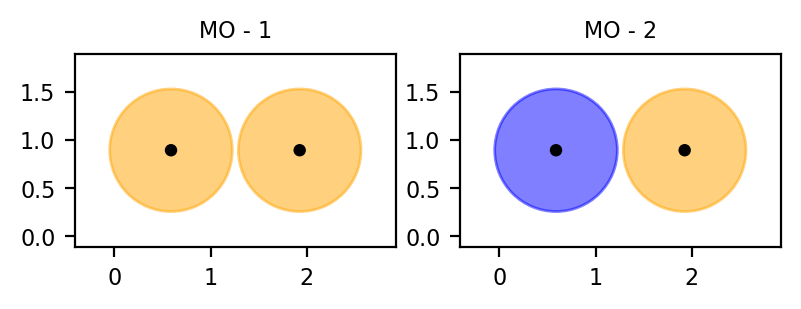

In [4]:
# Create an instance of the Huckel class and run the computation
huckel = Huckel(filename='ethylene.xyz', charge=0)
huckel.run()

# Plot the molecular orbitals using the plot method
huckel.plot(huckel.C, label='MO',size=2)

## Orbital occupation and total energy 

Once we have obtained the energy levels, we need to determine the number of electrons that occupy each orbital.
We will store this information in the occupation number vector
$$
\mathbf{n} = (n_1, n_2, \ldots, n_N)
$$
where the $i$-th element $n_i \in \{ 0, 1, 2 \}$ is the number of electrons that occupy a given energy level $\varepsilon_i$.

Due to the Pauli exclusion principle (more on this in later tutorials), we can place at most two electrons in each orbital, one with spin up and one with spin down.
In occupying the orbitals, we will follow a simplified version of the **Aufbau** principle: we will fill the orbitals starting from the lowest energy ones with two electrons until we run out of electrons, or if we are left with only one electron, we will occupy the next available orbital with one electron.

<div class="alert alert-block alert-danger">
<b>WARNING</b>: It is important to be aware that the way we have computed the occupation number may not correctly handle certain situations with degenerate levels, like the ones shown below where it is possible to have either low or high spin states.
<center><img src="img/occupation.png" width="525" /></center>
</div>

From the occupation numbers, we can compute the total energy ($E$), which we obtain by summing the orbital energies multiplied by the corresponding occupation
$$
E = \sum_{i=1}^{N} \varepsilon_i n_i = \mathrm{diag}(\boldsymbol \varepsilon) \cdot \mathbf{n}
$$
On the right-hand side of this equation, we expressed $E$ as the dot product between the diagonal of the $\boldsymbol \varepsilon$ matrix, $\mathrm{diag}(\boldsymbol \varepsilon)$, and the occupation number vector.

We will start by adding a function to the class `Huckel` (`find_occupation`) that computes the occupation number vector.
Here, we define the function `compute_occupation` and update the `run` function to call it. Then we inject these functions into the class definition with the lines
```python
Huckel.run = run
Huckel.compute_occupation = compute_occupation
```
This step redefines the function `Huckel.run` and creates the function `Huckel.compute_occupation` in the class. This technique lets us change parts of the class Hückel without repeating the part of the code that has not changed.

In [5]:
def compute_occupation(self):
    """This function finds the occupation of the molecular orbitals."""
    
    self.nel = len(self.ε) - self.charge
    print(f'Number of electrons: {self.nel}')

    # find the occupied states
    ndocc = self.nel // 2
    nsocc = self.nel % 2
    print(f'Number of doubly occupation states: {ndocc}')
    print(f'Number of singly occupied states: {nsocc}')
    self.occupation = np.zeros_like(self.ε)
    self.occupation[:ndocc] = 2
    if nsocc:
        self.occupation[ndocc] = 1

def run(self):
    """Performs a Hückel method computation."""
    print(f'Running Huckel method on file {self.filename}')

    self.atoms = self.read_geometry()
    print(f'Found {len(self.atoms)} carbon atoms')

    print('Building Hückel Hamiltonian')
    self.H = self.build_huckel_hamiltonian()

    print('Solving eigenvalue problem')
    self.solve_eigenvalues(self.H)

    self.compute_occupation()
    
# add/replace methods in the Huckel class
Huckel.run = run
Huckel.compute_occupation = compute_occupation

huckel = Huckel(filename='ethylene.xyz', charge=0)
huckel.run()

Running Huckel method on file ethylene.xyz
Found 2 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-12.2 -10.6] eV
Number of electrons: 2
Number of doubly occupation states: 1
Number of singly occupied states: 0


Next, we will add a function to compute the total energy. Here, we define `compute_energy` and inject it into the Hückel class. We also update the `run` method

In [6]:
def compute_energy(self):
    """This function computes the energy of the molecule."""
    self.energy = np.dot(self.ε, self.occupation)
    print(f'Total energy: {self.energy:.3f} eV')

def run(self):
    print(f'Running Hückel method on file {self.filename}')

    self.atoms = self.read_geometry()
    print(f'Found {len(self.atoms)} carbon atoms')

    print('Building Hückel Hamiltonian')
    H = self.build_huckel_hamiltonian()

    print('Solving eigenvalue problem')
    self.solve_eigenvalues(H)

    self.compute_occupation()

    self.compute_energy()

# add/replace methods in the Huckel class
Huckel.run = run
Huckel.compute_energy = compute_energy

Now we have a fully functional version of the Hückel class. Let's apply it to a classic problem: estimating the delocalization energy of conjugated hydrocarbons.

## Example: Stabilization energy of benzene 🧪

In hydrocarbons with alternating single and double bonds, the molecular orbitals can delocalize, decreasing the energy.
We can quantify this effect via the delocalization energy, defined as the difference between the energy of the localized π orbitals (computed from the energy of ethylene) minus the Hückel energy of the molecule under consideration
$$
E_\mathrm{deloc.} = E(\mathrm{C_2H_4}) \times \text{number of π bonds} - \sum_i n_i \varepsilon_i
$$

We will estimate this energy for two molecules, hexatriene and benzene

<center><img src="img/example_1.png" width="400" /></center>

To begin, we run a computation on ethylene and store the energy in the variable `ethylene_energy`

In [7]:
ethylene = Huckel(filename='ethylene.xyz', charge=0)
ethylene.run()
energy_ethylene = ethylene.energy

Running Hückel method on file ethylene.xyz
Found 2 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-12.2 -10.6] eV
Number of electrons: 2
Number of doubly occupation states: 1
Number of singly occupied states: 0
Total energy: -24.400 eV


Next, we compute the energy of hexatriene and benzene

In [8]:
hexatriene = Huckel(filename='hexatriene.xyz', charge=0)
hexatriene.run()
energy_hexatriene = hexatriene.energy

Running Hückel method on file hexatriene.xyz
Found 6 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-12.84155019 -12.39758368 -11.75603349 -11.04396651 -10.40241632
  -9.95844981] eV
Number of electrons: 6
Number of doubly occupation states: 3
Number of singly occupied states: 0
Total energy: -73.990 eV


In [9]:
benzene = Huckel(filename='benzene.xyz', charge=0)
benzene.run()
energy_benzene = benzene.energy

Running Hückel method on file benzene.xyz
Found 6 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-13.  -12.2 -12.2 -10.6 -10.6  -9.8] eV
Number of electrons: 6
Number of doubly occupation states: 3
Number of singly occupied states: 0
Total energy: -74.800 eV


We can now estimate the delocalization energy, converting the energy from eV to kcal mol<sup>-1</sup> when printing it:

In [10]:
E_deloc_hexatriene = 3 * energy_ethylene - energy_hexatriene
E_deloc_benzene = 3 * energy_ethylene - energy_benzene

print(f'Delocalization energy of hexatriene: {E_deloc_hexatriene * 23.06:.2f} kcal mol^-1')
print(f'Delocalization energy of benzene:    {E_deloc_benzene * 23.06:.2f} kcal mol^-1')

Delocalization energy of hexatriene: 18.23 kcal mol^-1
Delocalization energy of benzene:    36.90 kcal mol^-1


Notice the large difference between the delocalization energy in these two systems. The extra stabilization we see in benzene is one of the feature of the concept of **aromaticity**.

## Mulliken population analysis 🔍

At this point, we are ready to analyze the distribution of electrons in the molecule. We will perform a simple analysis based on the approach developed by Mulliken.

To understand how Mulliken's analysis is formulated, we start from the interpretation of the square of the wave function $|\psi(\mathbf{r})|^2$ as a probability distribution (here $\mathbf{r}$ is the vector of $x$, $y$, and $z$ coordinates).
This probability distribution is equivalent to the charge density of an electron occupying this orbital.
It follows then that the total electron density, $\rho(\mathbf{r})$, is the sum of the contribution of each occupied orbital times its occupation number
$$
\rho(\mathbf{r}) = \sum_i |\psi_i(\mathbf{r})|^2 n_i
$$
Integrating the total electron density over all space gives us the total number of electrons $N$.
$$
\int \rho(\mathbf{r}) \; d\mathbf{r} = \sum_i n_i \int |\psi_i(\mathbf{r})|^2  \; d\mathbf{r} = N
$$

How can we use these expressions to obtain the distribution of electrons in our molecule? The basic idea is to partition the density into contributions from atomic orbitals.
We first recognize that the last equation can also be written as
$$
\sum_i n_i \langle \psi_i|\psi_i \rangle  = N
$$
since, by definition, $\int |\psi_i(\mathbf{r})|^2 \; d\mathbf{r} = \langle \psi_i|\psi_i \rangle$.

Next, we will expand the orbitals into the atomic basis
$$
|\psi_i \rangle = \sum_\mu |\chi_\mu \rangle C_{\mu i}
$$
from which we can write
$$
\langle \psi_i|\psi_i \rangle = \sum_\mu \sum_\nu C_{\mu i}^* \underbrace{\langle \chi_\mu | \chi_\nu \rangle}_{\delta_{\mu \nu}}  C_{\nu i}
= \sum_\mu C_{\mu i}^* C_{\mu i}
$$
Using this result we can express the number of electrons as
$$
\sum_i n_i \langle \psi_i|\psi_i \rangle  = \sum_i n_i \sum_\mu C_{\mu i}^* C_{\mu i} = \sum_\mu \sum_i n_i C_{\mu i}^* C_{\mu i} = \sum_\mu p_{\mu}
$$
where we have introduced the Mulliken population vector $p_{\mu}$ with elements defined as
$$
p_{\mu} = \sum_i n_i C_{\mu i}^* C_{\mu i}
$$
We interpret the quantity $p_{\mu}$ as the number of electrons on the atom on which the 2p<sub>z</sub> orbital is located.
Therefore, we can express the number of electrons as a sum of atomic contributions from the Mulliken population.
The charge on the corresponding atom ($q_\mu$) is given by
$$
q_\mu = 1 - p_{\mu}
$$
where the 1 is the charge of the C atom with an empty 2p<sub>z</sub> orbital.

Note that in the case of Hückel theory, we can use the atomic orbital labels ($\mu, \nu, \cdots$) to denote **both atomic orbitals and atoms** since there is a one-to-one correspondence between atoms and the atomic orbitals that come along with them.
This is not the case for extension of Hückel theory that consider more than one orbital per atom and in general for MO theories.

## Coding the Mulliken charges 🧑‍💻

In practice, to compute the diagonal part of this matrix, we first square the elements of the coefficient matrix (`C**2`), which computes
$$
M_{\mu i} = (C_{\mu i})^2
$$
and then multiply $M_{\mu i}$ with the occupation number vector $n_i$ with the `np.dot` function to compute
$$
\sum_i M_{\mu i} n_i = \sum_i (C_{\mu i})^2 n_i = p_{\mu}
$$
Putting everything together, we can compute the Mulliken population as
```
np.dot(self.C**2, self.occupation)
```
This code will return a **vector** of numbers. To evaluate the charges, we can subtract the Mulliken population vector from the scalar 1
```
1 - np.dot(self.C**2, self.occupation)
```
When we perform this operation, `numpy` will **broadcast** the value one, which means that it will convert it into a vector and correctly evaluate the Mulliken charges
$$
1 - (p_1, p_2, \ldots) \rightarrow (1, 1, \ldots) - (p_1, p_2, \ldots) = (1 - p_1, 1 - p_2, \ldots) = (q_1, q_2, \ldots)
$$

In the code below, we create a new function, `population_analysis`, to compute the Mulliken charges and modify the `run` function to execute it

In [11]:
def population_analysis(self):
    """This function computes the Mulliken charges of the molecule."""
    self.mulliken_charges = 1 - np.dot(self.C**2, self.occupation)
    print(f'Mulliken charges: {self.mulliken_charges}')

def run(self):
    print(f'Running Hückel method on file {self.filename}')

    self.atoms = self.read_geometry()
    print(f'Found {len(self.atoms)} carbon atoms')

    print('Building Hückel Hamiltonian')
    self.H = self.build_huckel_hamiltonian()

    print('Solving eigenvalue problem')
    self.solve_eigenvalues(self.H)

    self.compute_occupation()

    self.compute_energy()

    self.population_analysis() # <- call the population analysis method after computing the energy
    
# add/replace methods in the Huckel class
Huckel.run = run
Huckel.population_analysis = population_analysis

huckel = Huckel(filename='ethylene.xyz', charge=0)
huckel.run()

Running Hückel method on file ethylene.xyz
Found 2 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-12.2 -10.6] eV
Number of electrons: 2
Number of doubly occupation states: 1
Number of singly occupied states: 0
Total energy: -24.400 eV
Mulliken charges: [2.22044605e-16 2.22044605e-16]


## Example: The charge distribution in azulene 🧪

Let's apply this updated code to compute the charges in the azulene molecule. In this example we will use the following numbering scheme to label the atomic orbitals

<center><img src="img/azulene_numbering.png" width="200" /></center>

In [12]:
azulene = Huckel(filename='azulene.xyz', charge=0)
azulene.run()

Running Hückel method on file azulene.xyz
Found 10 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-13.24822148 -12.72125785 -12.48453944 -12.10958019 -11.781808
 -11.07968614 -10.80988776 -10.13662552  -9.90462882  -9.72376481] eV
Number of electrons: 10
Number of doubly occupation states: 5
Number of singly occupied states: 0
Total energy: -124.691 eV
Mulliken charges: [ 0.14505434  0.01355315  0.12999862  0.01355315  0.14505434 -0.0274276
 -0.0274276  -0.17287934 -0.04659971 -0.17287934]


Since we have stored the charges as a vector in the member variable `mulliken_charges` we can plot it with the `plot` function

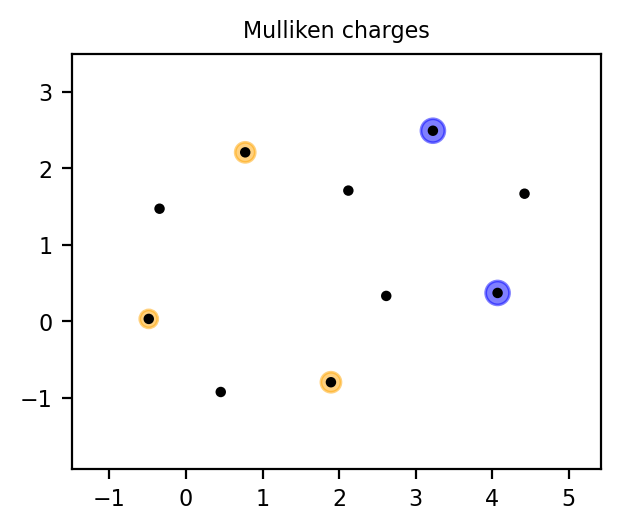

In [13]:
azulene.plot(azulene.mulliken_charges, label='Mulliken charges',size=3)

This figure shows that the C atoms 1, 3, and 5 carry small positive charges (yellow), while atoms 8 and 10 carry small negative charges (blue). We can estimate the charge on each ring by adding the atomic charges and splitting the charges on atoms 6 and 7 (shared by the two rings) equally among the two atoms.

When we do this, as shown below, we find that the 7-member ring is positively charged (+0.42) while the 5-member right is negatively charged (-0.42).
This is an example of a nontrivial prediction by Hückel's theory that can be confirmed experimentally.

In [14]:
charge_on_7_ring = sum(huckel.mulliken_charges[0:5]) + 0.5 * sum(huckel.mulliken_charges[5:7])
charge_on_5_ring = sum(huckel.mulliken_charges[7:10]) + 0.5 * sum(huckel.mulliken_charges[5:7])
print(f'Charge on 7-membered ring: {charge_on_7_ring:.3f}')
print(f'Charge on 5-membered ring: {charge_on_5_ring:.3f}')

Charge on 7-membered ring: 0.000
Charge on 5-membered ring: 0.000


## Spin density and π bond order 🏋️

Our last task will be to extend the orbital population analysis to compute the spin density and the bond order.
To evaluate these quantities, we will introduce the spin up and down density matrices, defined as
$$
P^\uparrow_{\mu \nu} = \sum_{i} C_{\mu i} n_i^\uparrow C_{\nu i}
$$
$$
P^\downarrow_{\mu \nu} = \sum_{i} C_{\mu i} n_i^\downarrow C_{\nu i}
$$
where $n_i^\uparrow$ and $n_i^\downarrow$ are the number of spin up and down electrons in the i-$th$ orbital.
The sum of the spin up and spin down occupation numbers is the orbital occupation number
$$
n_i^\uparrow + n_i^\downarrow = n_i
$$
Note that **in the literature** these are also called the $\alpha$ and $\beta$ spin densities.

Why did we introduce these new quantities? It is easy to show that the Mulliken population charges are the diagonal elements of the sum of the $P^\uparrow_{\mu \nu}$ and $P^\downarrow_{\mu \nu}$ matrices.
Here is the derivation
$$
\begin{split}
P^\uparrow_{\mu \mu} + P^\downarrow_{\mu \mu}
& = \sum_{i} C_{\mu i} n_i^\uparrow C_{\mu i} + \sum_{i} C_{\mu i} n_i^\downarrow C_{\mu i} \\
& = \sum_{i} C_{\mu i} (n_i^\uparrow + n_i^\downarrow) C_{\mu i} \\
& = \sum_{i} C_{\mu i} n_i C_{\mu i} \\
& = p_\mu
\end{split}
$$

To quantify the excess of up or down spin in the molecule (spin polarization) we can evaluate a quantity analogous to the charge, the spin density ($p^\mathrm{s}_{\mu}$).
We define the spin density matrix as the difference between the spin up and spin down densities
$$
P^\mathrm{s}_{\mu \nu} = P^\uparrow_{\mu \nu} - P^\downarrow_{\mu \nu}
$$
The spin density on each atom is given by the diagonal element of the spin density matrix
$$
p^\mathrm{s}_{\mu} = P^\mathrm{s}_{\mu \mu}
$$

From the spin up and down density matrices, we can compute an estimate of the bond order due to the π electrons between atoms $\mu$ and $\nu$
$$
B^{\pi}_{\mu \nu} = 2 ( |P^\uparrow_{\mu \nu}|^2 + |P^\downarrow_{\mu \nu}|^2)
$$

This shows that we can perform a full Mulliken analysis by first computing $P^\uparrow_{\mu \nu}$ and $P^\downarrow_{\mu \nu}$ and then combining them to obtain the charge and spin distribution and the bond order.

## Coding spin density and bond order 🧑‍💻

In the following code, we modify the `population_analysis` function to find Mulliken charges, spin density, and bond order

In [15]:
def population_analysis(self):
    """This function performs a population analysis of the molecule."""
    # find the spin up and spin down occupation numbers. Singly occupied states are counted as spin up.
    spin_up_occupation = [1 if x == 1 or x == 2 else 0  for x in self.occupation]
    spin_down_occupation = [1 if x == 2 else 0  for x in self.occupation]

    # compute the density matrices
    self.density_up = self.C @ np.diag(spin_up_occupation) @ self.C.T
    self.density_down = self.C @ np.diag(spin_down_occupation) @ self.C.T

    # compute the Mulliken charges and spin density
    self.mulliken_charges = 1 - np.diag(self.density_up + self.density_down)
    self.spin_density = np.diag(self.density_up - self.density_down)

    print(f'\nMulliken charges')
    print('Atom   Charge     Spin')
    for i in range(len(self.atoms)):
        print(f'{i + 1:3} {self.mulliken_charges[i]:+9.3f} {self.spin_density[i]:+9.3f}')

    # compute the bond order matrix
    self.B = 2 * (self.density_up ** 2 + self.density_down ** 2)
    print('\nπ Bond order')
    print('Atom pair  Bond order')
    for i in range(len(self.atoms)):
        for j in range(i + 1, len(self.atoms)):
            if i != j:
                print(f'{i+ 1:3} {j + 1:3}       {self.B[i, j]:.3f}')

def run(self):
    print(f'Running Hückel method on file {self.filename}')

    self.atoms = self.read_geometry()
    print(f'Found {len(self.atoms)} carbon atoms')

    print('Building Hückel Hamiltonian')
    self.H = self.build_huckel_hamiltonian()

    print('Solving eigenvalue problem')
    self.solve_eigenvalues(self.H)

    self.compute_occupation()

    self.compute_energy()

    self.population_analysis()
    
Huckel.run = run
Huckel.population_analysis = population_analysis

Let's apply this new code to compute the bond order in butadiene

In [16]:
huckel = Huckel(filename='butadiene.xyz', charge=0)
huckel.run()

Running Hückel method on file butadiene.xyz
Found 4 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-12.69442719 -11.89442719 -10.90557281 -10.10557281] eV
Number of electrons: 4
Number of doubly occupation states: 2
Number of singly occupied states: 0
Total energy: -49.178 eV

Mulliken charges
Atom   Charge     Spin
  1    -0.000    +0.000
  2    +0.000    +0.000
  3    +0.000    +0.000
  4    +0.000    +0.000

π Bond order
Atom pair  Bond order
  1   2       0.800
  1   3       0.000
  1   4       0.200
  2   3       0.200
  2   4       0.000
  3   4       0.800


In this case, all carbon atoms have the same charge and spin (zero). The bond order analysis indicates a 0.8 π bond order between carbon atoms 1 and 2 and a smaller (0.2) π bond order between atoms 1 and 4.
One interesting aspect of the Hückel theory prediction is a partial double bond between atoms 2 and 3. This implies that the bond among these two atoms is not simply of σ type and that rotations of groups connected to these two atoms must be somewhat hindered.

Next, let's consider the butadiene cation and analyze the electron distribution

In [17]:
huckel = Huckel(filename='butadiene.xyz', charge=1)
huckel.run()

Running Hückel method on file butadiene.xyz
Found 4 carbon atoms
Building Hückel Hamiltonian
Solving eigenvalue problem
Eigenvalues: [-12.69442719 -11.89442719 -10.90557281 -10.10557281] eV
Number of electrons: 3
Number of doubly occupation states: 1
Number of singly occupied states: 1
Total energy: -37.283 eV

Mulliken charges
Atom   Charge     Spin
  1    +0.362    +0.362
  2    +0.138    +0.138
  3    +0.138    +0.138
  4    +0.362    +0.362

π Bond order
Atom pair  Bond order
  1   2       0.500
  1   3       0.100
  1   4       0.138
  2   3       0.362
  2   4       0.100
  3   4       0.500


In the cation, most of the positive charge is found on the terminal atoms (1 and 4).
Hückel theory also predicts a higher π bond order between atoms 2 and 3, increasing from 0.2 (neutral) to 0.362 (cation).

This example concludes this tutorial. I hope you learned something useful from it, and I look forward to seeing you for the next one!

## The final Python code

Here is the complete definition of the Huckel class with all the additions we made in this tutorial

In [18]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

class Huckel:
    def __init__(self, filename, charge, r_cutoff=1.5, alpha=-11.4, beta=-0.8):
        self.filename = filename
        self.charge = charge
        self.r_cutoff = r_cutoff
        self.alpha = alpha
        self.beta = beta

    def run(self):
        print(f'Running Hückel method on file {self.filename}')

        self.atoms = self.read_geometry()
        print(f'Found {len(self.atoms)} carbon atoms')

        print('Building Hückel Hamiltonian')
        self.H = self.build_huckel_hamiltonian()

        print('Solving eigenvalue problem')
        self.solve_eigenvalues(self.H)

        self.compute_occupation()

        self.compute_energy()

        self.population_analysis()

    def read_geometry(self):
        """This function reads the geometry of a molecule from an XYZ file
        and stores the atom symbol and coordinates of the carbon atoms in a list of tuples.
        """
        atoms = []
        with open(self.filename, "r") as f:
            lines = f.readlines() # read all lines into a list
            for line in lines[2:]: # skip the first two lines
                parts = line.split() # split the line into parts
                symbol = parts[0]
                if symbol == "C": # only keep carbon atoms
                    xyz = np.array([float(x) for x in parts[1:4]])
                    atoms.append((symbol, xyz))
        return atoms

    def build_huckel_hamiltonian(self):
        """This function builds the Hückel Hamiltonian matrix given a list of atoms."""
        N = len(self.atoms) # find the number of atoms from the length of the atoms list
        H = np.zeros((N, N))
        np.fill_diagonal(H, self.alpha)
        for i in range(N):
            # only loop over half of the pairs, excluding the diagonal
            for j in range(i + 1, N):
                r_i = self.atoms[i][1]
                r_j = self.atoms[j][1]
                distance = np.linalg.norm(r_i - r_j)
                if distance < self.r_cutoff:
                    H[i, j] = H[j, i] = self.beta
        return H

    def solve_eigenvalues(self, H):
        """This function solves the eigenvalue problem H C = ε C."""
        self.ε, self.C = np.linalg.eigh(H)
        print(f'Eigenvalues: {self.ε} eV')

    def compute_occupation(self):
        """This function finds the occupation of the molecular orbitals."""
        
        self.nel = len(self.ε) - self.charge
        print(f'Number of electrons: {self.nel}')

        # find the occupied states
        ndocc = self.nel // 2
        nsocc = self.nel % 2
        print(f'Number of doubly occupation states: {ndocc}')
        print(f'Number of singly occupied states: {nsocc}')
        self.occupation = np.zeros_like(self.ε)
        self.occupation[:ndocc] = 2
        if nsocc:
            self.occupation[ndocc] = 1

    def compute_energy(self):
        """This function computes the energy of the molecule."""
        self.energy = np.dot(self.ε, self.occupation)
        print(f'Total energy: {self.energy:.3f} eV')


    def population_analysis(self):
        """This function performs a population analysis of the molecule."""
        # find the spin up and spin down occupation numbers. Singly occupied states are counted as spin up.
        spin_up_occupation = [1 if x == 1 or x == 2 else 0  for x in self.occupation]
        spin_down_occupation = [1 if x == 2 else 0  for x in self.occupation]

        # compute the density matrices
        self.density_up = self.C @ np.diag(spin_up_occupation) @ self.C.T
        self.density_down = self.C @ np.diag(spin_down_occupation) @ self.C.T

        # compute the Mulliken charges and spin density
        self.mulliken_charges = 1 - np.diag(self.density_up + self.density_down)
        self.spin_density = np.diag(self.density_up - self.density_down)

        print(f'\nMulliken charges')
        print('Atom   Charge     Spin')
        for i in range(len(self.atoms)):
            print(f'{i + 1:3} {self.mulliken_charges[i]:+9.3f} {self.spin_density[i]:+9.3f}')

        # compute the bond order matrix
        self.B = 2 * (self.density_up ** 2 + self.density_down ** 2)
        print('\nπ Bond order')
        print('Atom pair  Bond order')
        for i in range(len(self.atoms)):
            for j in range(i + 1, len(self.atoms)):
                if i != j:
                    print(f'{i+ 1:3} {j + 1:3}       {self.B[i, j]:.3f}')
     
    def plot(self, coefficients, label=None, size=4):
        """
        A function to plot molecular orbitals with given coordinates and coefficients.
        The probability of finding an electron is proportional to the area of the circles.
        """
        coordinates = [(atom[1][0], atom[1][1]) for atom in self.atoms]  # Extract coordinates

        # Ensure coefficients is 2D (matrix-like) so we can plot single or multiple orbitals
        if np.ndim(coefficients) == 1:
            coefficients = coefficients[:, np.newaxis]

        num_plots = coefficients.shape[1]  # Number of columns determines the number of plots

        # Compute the grid size to organize plots (e.g., 3x2 for 6 plots)
        n_cols = 2 # 1 #3 #int(np.ceil(np.sqrt(num_plots)))  # Columns in the grid
        n_rows = int(np.ceil(num_plots / n_cols))  # Rows in the grid

        # Create a grid of subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(size * n_cols, size * n_rows))
        axes = np.ravel(axes)  # Flatten the axes array for easy iteration

        # Plot each column of coefficients in its own subplot
        for i in range(num_plots):
            ax = axes[i]
            ax.set_aspect('equal', 'box')

            # Set plot limits with padding
            x_vals, y_vals = zip(*coordinates)
            ax.set_xlim(min(x_vals) - 1, max(x_vals) + 1)
            ax.set_ylim(min(y_vals) - 1, max(y_vals) + 1)

            # Plot molecular orbitals and atoms
            for (x, y), c in zip(coordinates, coefficients[:, i]):
                radius = np.abs(c) * 0.9
                color = 'orange' if c > 0 else 'blue'
                mo = plt.Circle((x, y), radius, color=color, alpha=0.5)
                ax.add_patch(mo)
                atom = plt.Circle((x, y), 0.05, color='black')
                ax.add_patch(atom)

            # Set smaller font size for axes labels
            ax.tick_params(axis='both', which='major', labelsize=8)
            if label:
                if num_plots > 1:
                    ax.set_title(f"{label} - {i+1}", fontsize=8)
                else:
                    ax.set_title(f"{label}", fontsize=8)

        # Hide any unused subplots if num_plots < n_rows * n_cols
        for j in range(num_plots, n_rows * n_cols):
            fig.delaxes(axes[j])

        # Adjust layout to avoid overlaps
        plt.tight_layout()
        plt.show()